CNN model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import keras_tuner

In [6]:
picture_size = 48
folder_path = "C:/Users/mirak/Documents/DeepLearning_sthlm_gbg_v35_v40/Final_assignment_Ekaterina_Zhiganova/data"

In [ ]:
num_features = 2304

In [8]:
batch_size = 5
expression = "Happy"

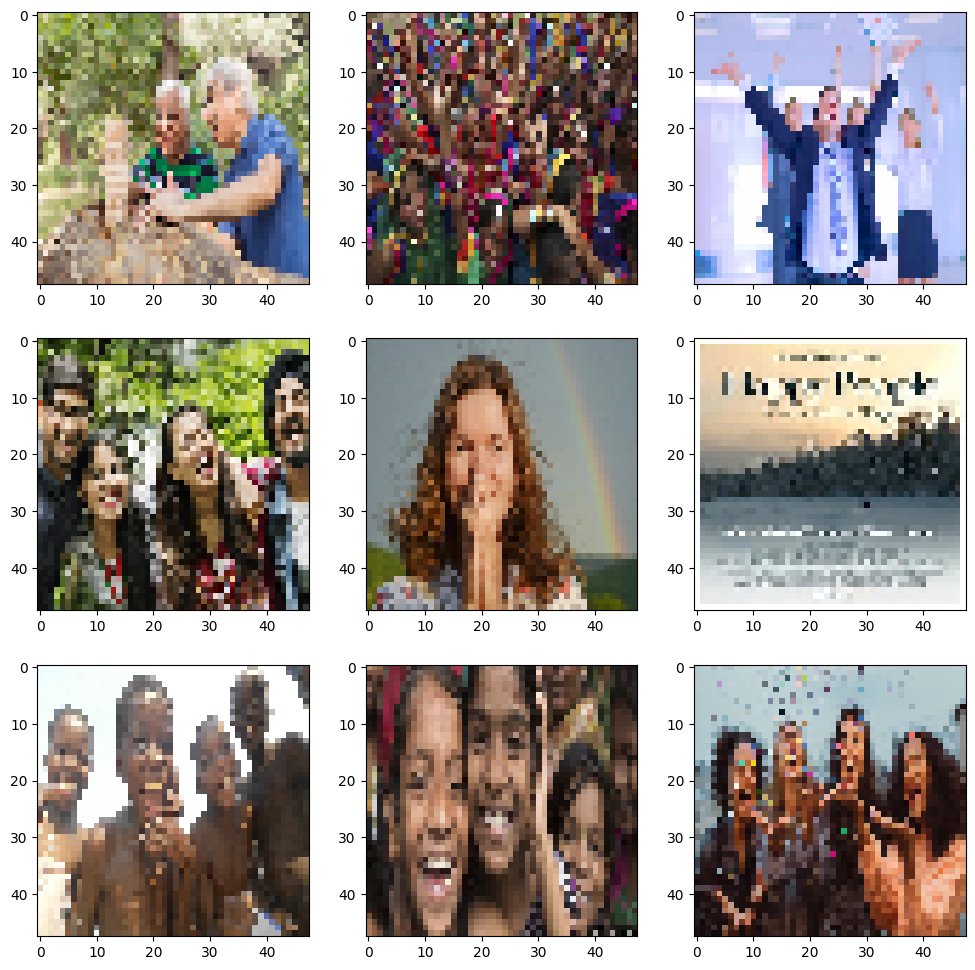

In [6]:
plt.figure(figsize = (12,12))
for i in range (1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"/data/"+expression+"/"+os.listdir(folder_path+"/data/"+expression)[i], 
                   target_size = (picture_size,picture_size))
    plt.imshow(img)
plt.show()

In [62]:
import cv2

In [7]:
image_size = (48, 48)
batch_size = 9

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    folder_path +"/data",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 238 files belonging to 3 classes.
Using 191 files for training.
Using 47 files for validation.


In [5]:
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

In [9]:
train_set = datagen_train.flow_from_directory(folder_path + "/Train/", 
                                              target_size = (picture_size,picture_size), 
                                              color_mode = "grayscale", batch_size = batch_size, 
                                              class_mode = "categorical", shuffle = True)

Found 153 images belonging to 3 classes.


In [10]:
validation_set = datagen_val.flow_from_directory(folder_path + "/Validation/", 
                                              target_size = (picture_size,picture_size), 
                                              color_mode = "grayscale",batch_size = batch_size, 
                                              class_mode = "categorical", shuffle = True)

Found 43 images belonging to 3 classes.


In [11]:
test_set = datagen_test.flow_from_directory(folder_path + "/Test/", 
                                              target_size = (picture_size,picture_size), 
                                              color_mode = "grayscale",batch_size = batch_size, 
                                              class_mode = "categorical", shuffle = True)

Found 41 images belonging to 3 classes.


In [13]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(48,48,1)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=5, max_value=200, step=5)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE),
                metrics=['accuracy'])

    return model

In [17]:
tuner = keras_tuner.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=10,
                     factor=3,
                     overwrite=True)

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint ("model_1.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
earlystopping = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

In [27]:
#4:37 minutes

tuner.search(train_set, epochs=10, callbacks = [earlystopping, checkpoint])

Trial 30 Complete [00h 00m 41s]
accuracy: 0.3442266583442688

Best accuracy So Far: 0.6666668057441711
Total elapsed time: 00h 08m 33s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [30]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(validation_set, epochs=10)
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
9/9 [==============================] - 2s 239ms/step - loss: 0.3170 - accuracy: 0.6434
Epoch 2/10
9/9 [==============================] - 2s 253ms/step - loss: 0.2604 - accuracy: 0.6667
Epoch 3/10
9/9 [==============================] - 2s 252ms/step - loss: 0.2484 - accuracy: 0.6667
Epoch 4/10
9/9 [==============================] - 2s 240ms/step - loss: 0.2476 - accuracy: 0.6667
Epoch 5/10
9/9 [==============================] - 2s 240ms/step - loss: 0.2468 - accuracy: 0.6667
Epoch 6/10
9/9 [==============================] - 2s 236ms/step - loss: 0.2460 - accuracy: 0.6667
Epoch 7/10
9/9 [==============================] - 2s 149ms/step - loss: 0.2453 - accuracy: 0.6667
Epoch 8/10
9/9 [==============================] - 2s 242ms/step - loss: 0.2446 - accuracy: 0.6667
Epoch 9/10
9/9 [==============================] - 2s 235ms/step - loss: 0.2442 - accuracy: 0.6667
Epoch 10/10
9/9 [==============================] - 2s 256ms/step - loss: 0.2433 - accuracy: 0.6667
Best epoch: 2


In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 11525     
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 11531 (45.04 KB)
Trainable params: 11531 (45.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.save("model_1.keras")

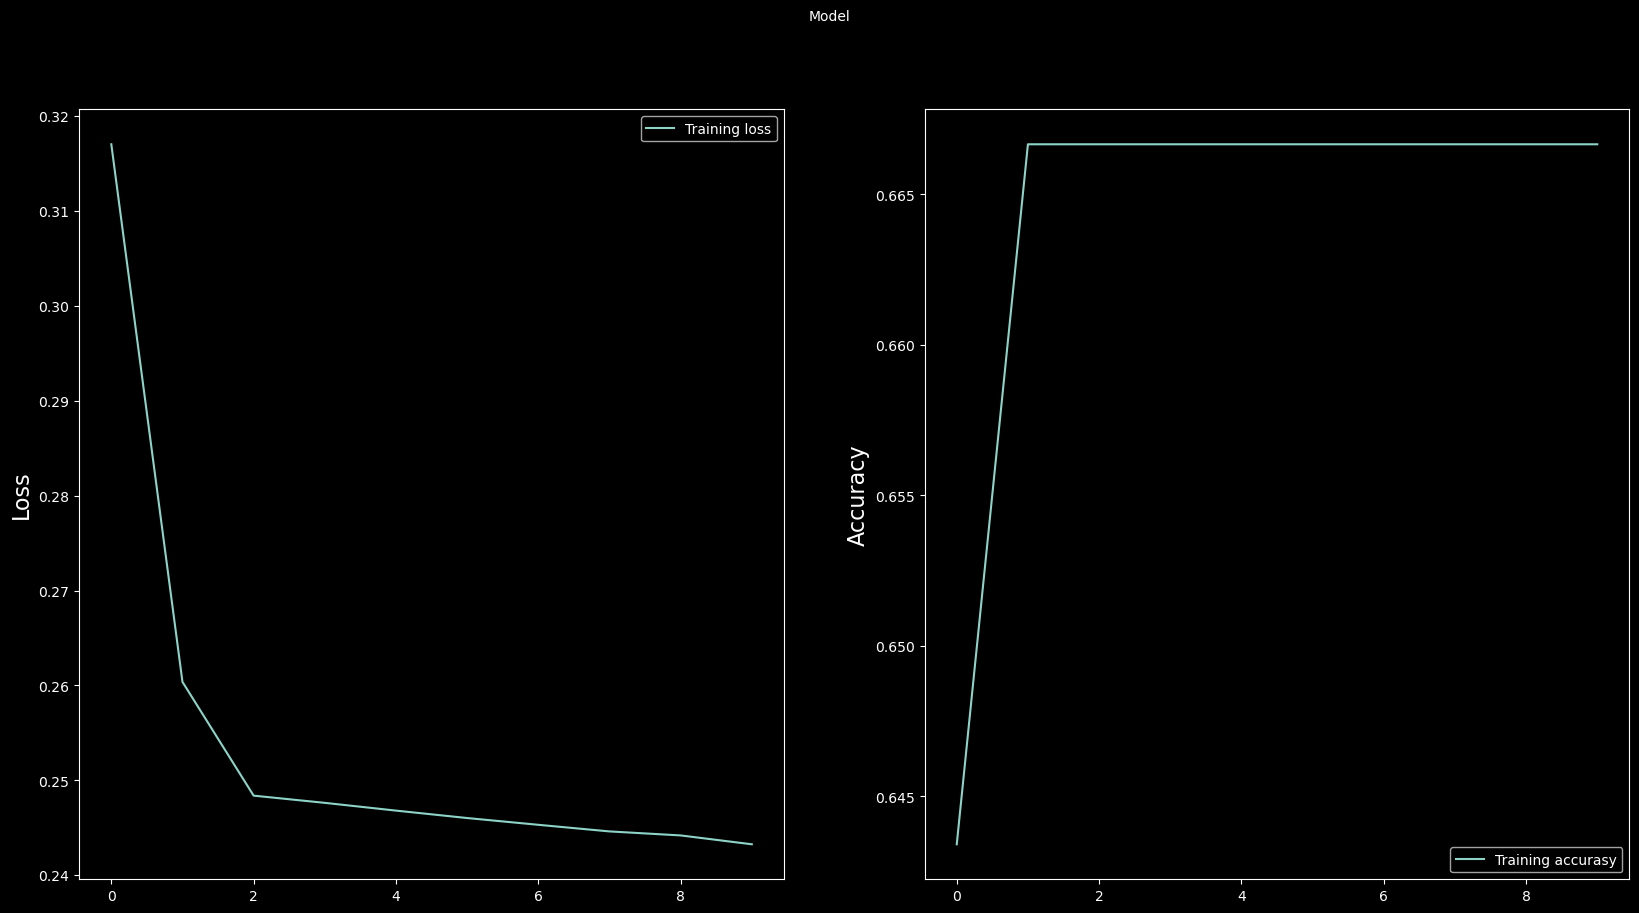

In [34]:
plt.style.use("dark_background")
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.suptitle("Model", fontsize = 10)
plt.ylabel("Loss", fontsize = 16)
plt.plot(history.history["loss"], label = "Training loss")
#plt.plot(history.history["val_loss"], label = "Validation loss")
plt.legend(loc = "upper right")

plt.subplot(1,2,2)
plt.ylabel("Accuracy", fontsize = 16)
plt.plot(history.history["accuracy"], label = "Training accurasy")
#plt.plot(history.history["val_accuracy"], label = "Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [35]:
model = tf.keras.saving.load_model("model_1.keras")

In [36]:
hypermodel = tuner.hypermodel.build(best_hps)

In [37]:
history_2 = hypermodel.fit(validation_set, epochs=best_epoch)

Epoch 1/2
9/9 [==============================] - 2s 226ms/step - loss: 0.2927 - accuracy: 0.6434
Epoch 2/2
9/9 [==============================] - 2s 246ms/step - loss: 0.2492 - accuracy: 0.6667


In [38]:
eval_result = hypermodel.evaluate(test_set)
print("[test loss, test accuracy]:", eval_result)

9/9 [==============================] - 1s 108ms/step - loss: 0.2488 - accuracy: 0.6667
[test loss, test accuracy]: [0.24875715374946594, 0.6666667461395264]


In [39]:
hypermodel.save("best_model_1.keras")

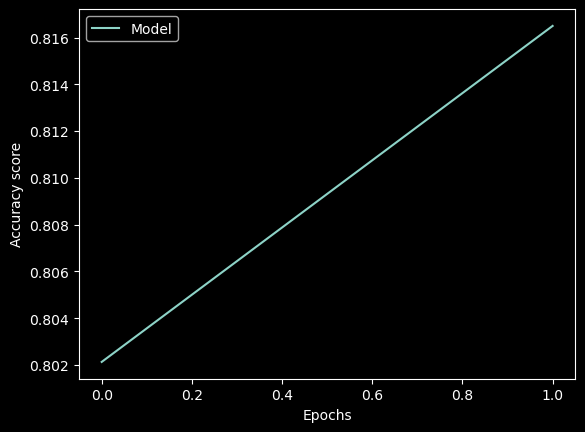

In [40]:
plt.plot(np.sqrt(history_2.history['accuracy']), label='Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.legend()

In [ ]:
Creation of the X_train, y_train arrays

In [ ]:
import glob
happy = glob.glob("C:/Users/mirak/Documents/DeepLearning_sthlm_gbg_v35_v40/Final_assignment_Ekaterina_Zhiganova/data/data/happy/*.jpeg")
angry = glob.glob("C:/Users/mirak/Documents/DeepLearning_sthlm_gbg_v35_v40/Final_assignment_Ekaterina_Zhiganova/data/data/angry/*.jpeg")
sad = glob.glob("C:/Users/mirak/Documents/DeepLearning_sthlm_gbg_v35_v40/Final_assignment_Ekaterina_Zhiganova/data/data/sad/*.jpeg")

In [ ]:
data = []
labels = []

In [ ]:
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(0)
    
for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(1)
    
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(2)

In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
X_2d = data.reshape(data.shape[0], -1)

In [ ]:
X_2d.shape

In [ ]:
y_2d = np.random.randint(0, 2, (22,))

In [ ]:
y_2d.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_2d, y_2d, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
Create a Decision Forest Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_full, y_train_full)

In [ ]:
#clf.save("model_2.h5")

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(tree_clf, params, verbose=1, cv=3)

In [ ]:
grid_search_cv.fit(X_train, y_train)

In [ ]:
#grid_search_cv.save("best_model_2.h5")

In [ ]:
grid_search_cv.best_params_

In [ ]:
tree_pred_val = grid_search_cv.predict(X_val)
tree_pred_val

In [ ]:
tree_pred_val.shape

In [ ]:
accuracy_score(y_val, tree_pred_val)